In [3]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from math import sqrt
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = Path(".")
TRAIN_JSON = DATA_DIR / "train_data.json"
TEST_JSON  = DATA_DIR / "test_data.json"
METRIC_NAMES_JSON = DATA_DIR / "metric_names.json"
METRIC_EMB_NPY = DATA_DIR / "metric_name_embeddings.npy"
SAMPLE_SUB = DATA_DIR / "sample_submission.csv"

TRAIN_EMB = Path("Train_pr_emb.npy")
TEST_EMB  = Path("Test_pr_emb.npy")
SUB_OUT   = "submission.csv"

In [5]:
train = json.load(open("train_data.json"))
test  = json.load(open("test_data.json"))
metric_names = json.load(open("metric_names.json"))
metric_embs = np.load("metric_name_embeddings.npy")
sample = pd.read_csv("sample_submission.csv")
sample2 = pd.read_csv("submission.csv")

metric_to_idx = {m: i for i, m in enumerate(metric_names)}

In [6]:
train_scores = [float(row["score"]) for row in train]
test_scores = sample2["score"].tolist()
sample_scores = pd.read_csv("sample_submission.csv")["score"].tolist()

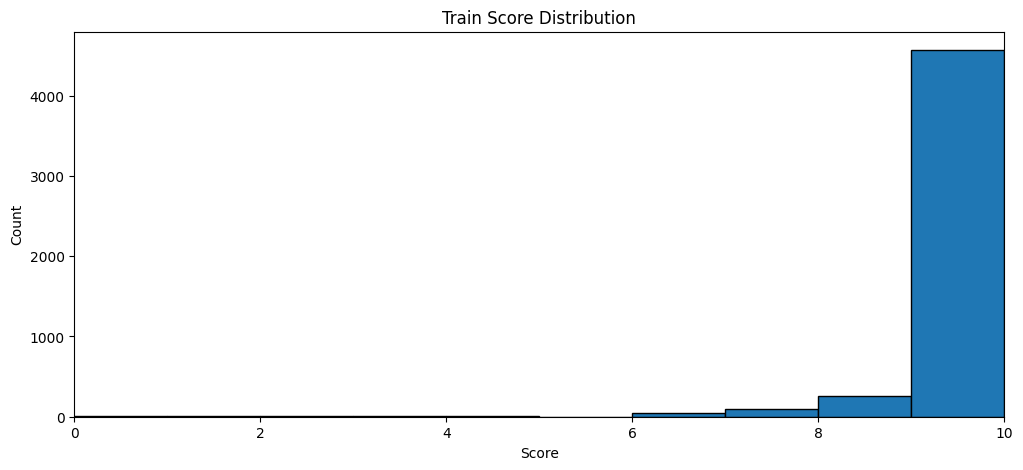

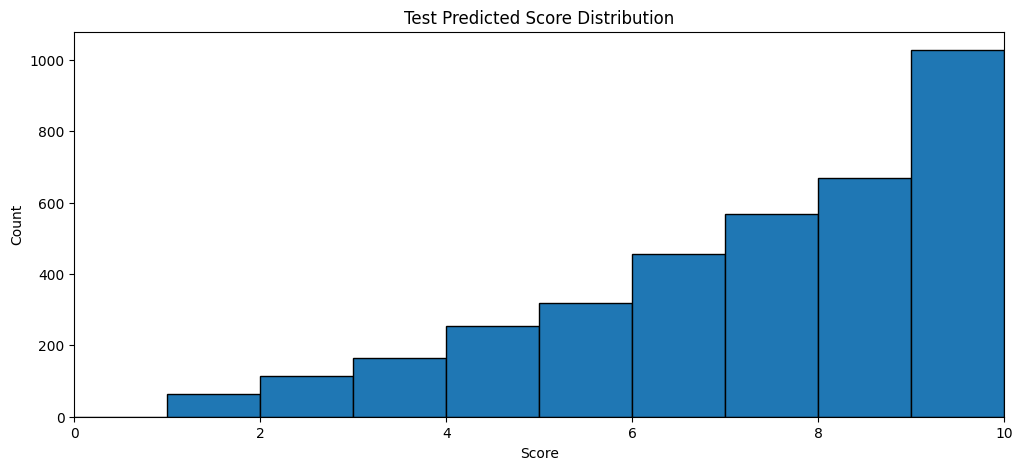

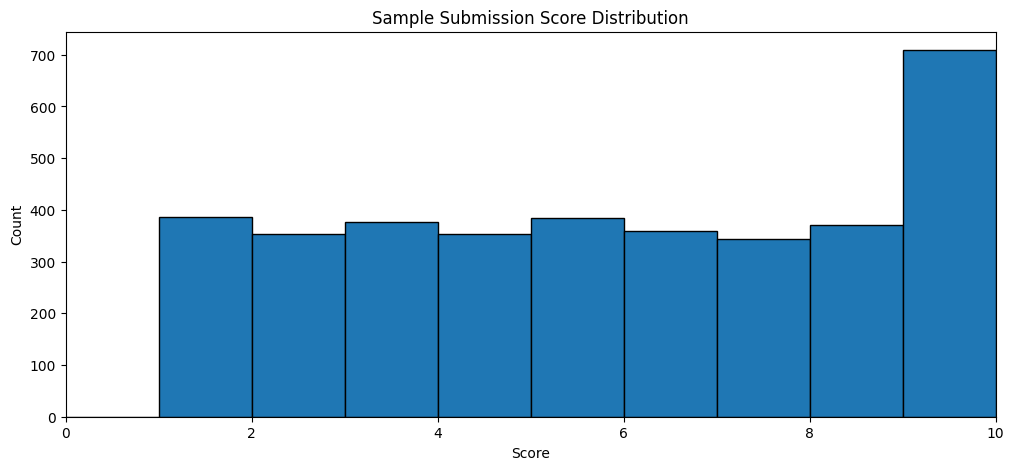

In [7]:
bins = np.linspace(0, 10, 11)

plt.figure(figsize=(12, 5))
plt.hist(train_scores, bins=bins, edgecolor="black")
plt.title("Train Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.xlim(0, 10)
plt.show()

plt.figure(figsize=(12, 5))
plt.hist(test_scores, bins=bins, edgecolor="black")
plt.title("Test Predicted Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.xlim(0, 10)
plt.show()

plt.figure(figsize=(12, 5))
plt.hist(sample_scores, bins=bins, edgecolor="black")
plt.title("Sample Submission Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.xlim(0, 10)
plt.show()

In [8]:
Batch_size = 8

In [9]:
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

In [10]:
def create_dataframe(raw_json, metric_names, metric_name_embs, is_train=True):
    metric_to_idx = {n: i for i, n in enumerate(metric_names)}
    rows = []
    for i, item in enumerate(raw_json):
        metric = item.get("metric_name")
        user = item.get("user_prompt") or ""
        resp = item.get("response") or ""
        sys  = item.get("system_prompt") or ""
        combined = f"User:{user}/Response:{resp}/System:{sys}"
        emb = metric_name_embs[metric_to_idx[metric]].astype(np.float32)
        row = {"ID": i+1, "metric_name": metric,
               "combined_text": combined,
               "metric_name_embedding": emb}
        if is_train:
            try:
                row["score"] = float(item.get("score", 0.0))
            except:
                row["score"] = 0.0
        rows.append(row)
    return pd.DataFrame(rows)

In [11]:
def ensure_array(column, name="unknown"):
    try:
        return np.vstack(column.values).astype(np.float32)
    except Exception:
        arr = [np.array(x, dtype=np.float32) for x in column.values]
        return np.vstack(arr)

In [12]:
def compute_features(metric_embs, context_embs):
    denom = (np.linalg.norm(metric_embs, axis=1, keepdims=True)
             * np.linalg.norm(context_embs, axis=1, keepdims=True) + 1e-8)
    cosine = np.sum(metric_embs * context_embs, axis=1, keepdims=True) / denom
    feats = np.concatenate([metric_embs, context_embs, cosine], axis=1)
    return feats

In [13]:
def preprocess_embeddings(df, is_train=True):
    keep_cols = ["metric_name_embedding", "context_embedding"]
    if is_train: keep_cols.append("score")
    dfp = df[keep_cols].copy()
    metric = ensure_array(dfp["metric_name_embedding"], "metric_name_embedding")
    context = ensure_array(dfp["context_embedding"], "context_embedding")
    features = compute_features(metric, context)
    df_final = pd.DataFrame(features)
    if is_train:
        df_final["score"] = dfp["score"].astype(float).values
    return df_final

In [14]:
def build_and_save_submission(df_test, preds, filename=SUB_OUT):
    preds = np.clip(preds, 1.0, 10.0)
    sub = pd.DataFrame({"ID": df_test["ID"].values, "score": preds})
    sub.to_csv(filename, index=False)
    print(f"✅ Submission saved: {filename} ({len(sub)} rows)")

In [15]:
def get_embeddings(df_train, df_test):
    if TRAIN_EMB.exists() and TEST_EMB.exists():
        print("Loading precomputed embeddings...")
        tr = np.load(TRAIN_EMB)
        te = np.load(TEST_EMB)
    else:
        print(f"Generating embeddings with batch_size = {Batch_size}...")
        model = SentenceTransformer("google/embeddinggemma-300m")

        def encode_texts_safe(texts):
            embs = []
            for i in range(0, len(texts), Batch_size):
                batch = texts[i:i+Batch_size]
                batch = ["(empty)" if not str(t).strip() else t for t in batch]
                out = model.encode(batch, show_progress_bar=False)
                embs.append(out)
            arr = np.vstack(embs).astype(np.float32)
            return arr

        tr = encode_texts_safe(df_train["combined_text"].tolist())
        te = encode_texts_safe(df_test["combined_text"].tolist())

        def fix_len(embs, n_rows):
            if len(embs) < n_rows:
                print(f"⚠️ Padding {n_rows - len(embs)} missing embeddings with zeros.")
                dim = embs.shape[1]
                pad = np.zeros((n_rows - len(embs), dim), dtype=np.float32)
                embs = np.vstack([embs, pad])
            elif len(embs) > n_rows:
                print(f"⚠️ Truncating {len(embs) - n_rows} extra embeddings.")
                embs = embs[:n_rows]
            return embs

        tr = fix_len(tr, len(df_train))
        te = fix_len(te, len(df_test))

        np.save(TRAIN_EMB, tr)
        np.save(TEST_EMB, te)

    return tr, te


In [ ]:
def main():
    train_raw = load_json(TRAIN_JSON)
    test_raw  = load_json(TEST_JSON)
    metric_names = load_json(METRIC_NAMES_JSON)
    metric_embs = np.load(METRIC_EMB_NPY)

    df_train = create_dataframe(train_raw, metric_names, metric_embs, True)
    df_test  = create_dataframe(test_raw,  metric_names, metric_embs, False)

    tr_pair, te_pair = get_embeddings(df_train, df_test)
    df_train["context_embedding"] = list(tr_pair)
    df_test["context_embedding"]  = list(te_pair)

    train_final = preprocess_embeddings(df_train, True)
    test_final  = preprocess_embeddings(df_test, False)

    y_raw = train_final["score"].values
    y = np.log1p(y_raw)
    X = train_final.drop(columns="score")
    X_test = test_final.values
    
    numeric_features = [c for c in X.columns]

    pca = PCA().fit(X[numeric_features])
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    n_components_95 = np.searchsorted(cum_var, 0.95) + 1
    print(n_components_95)

    preprocess_pipe = ColumnTransformer([
        ("scaler", StandardScaler(), numeric_features),
        ("pca", PCA(n_components=n_components_95, random_state=42), numeric_features)
    ], remainder="drop")

    mlp = MLPRegressor(hidden_layer_sizes=(256,128),
                       activation="tanh",
                       solver="adam",
                       learning_rate_init=0.001,
                       max_iter=1000,
                       random_state=42)
    mlp_pipe = Pipeline([
        ("preprocess", preprocess_pipe),
        ("model", mlp)
    ])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_rmse_log, fold_rmse_orig = [], []
    test_pred_log = np.zeros(len(X_test))
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X), 1):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]
        print(f"Fold {fold} training...")
        mlp_pipe.fit(X_tr, y_tr)
        y_val_pred_log = mlp_pipe.predict(X_val)
        rmse_log = sqrt(mean_squared_error(y_val, y_val_pred_log))
        y_val_pred = np.expm1(y_val_pred_log)
        y_val_true = np.expm1(y_val)
        rmse_orig = sqrt(mean_squared_error(y_val_true, y_val_pred))
        fold_rmse_log.append(rmse_log)
        fold_rmse_orig.append(rmse_orig)
        print(f"  Log RMSE={rmse_log:.4f} | Orig RMSE={rmse_orig:.4f}")
        test_pred_log += mlp_pipe.predict(X_test)/kf.n_splits

    print("\n=== 5-Fold Summary ===")
    print(f"Mean Log RMSE={np.mean(fold_rmse_log):.4f} ± {np.std(fold_rmse_log):.4f}")
    print(f"Mean Orig RMSE={np.mean(fold_rmse_orig):.4f} ± {np.std(fold_rmse_orig):.4f}")

    test_pred = np.expm1(test_pred_log)
    build_and_save_submission(df_test, test_pred, SUB_OUT)

In [21]:
main()

Loading precomputed embeddings...
478
Fold 1 training...
  Log RMSE=0.2592 | Orig RMSE=2.1253
Fold 2 training...
  Log RMSE=0.2338 | Orig RMSE=2.0780
Fold 3 training...
  Log RMSE=0.2623 | Orig RMSE=2.1291
Fold 4 training...
  Log RMSE=0.2607 | Orig RMSE=2.0889
Fold 5 training...
  Log RMSE=0.2636 | Orig RMSE=2.0967

=== 5-Fold Summary ===
Mean Log RMSE=0.2559 ± 0.0112
Mean Orig RMSE=2.1036 ± 0.0202
✅ Submission saved: submission.csv (3638 rows)
